*1) Data Reduction:*

In [1]:
#!pip install pyarrow
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
df_sb_f = pd.read_csv("data/df_timeseries_en.tsv.gz", compression="infer", sep="\t")
df_sb_f["datetime"] = pd.to_datetime(df_sb_f["datetime"])
df_sb_f.head(5)


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0


In [8]:
print("channel count in TimeSeries table:", df_sb_f['channel'].nunique())
df_sb_f["category"].unique()

chanell count in TimeSeries table: 133516


array(['Film and Animation', 'Music', 'Comedy', 'Gaming',
       'Science & Technology', 'Sports', 'Entertainment', 'Education',
       'Nonprofits & Activism', 'People & Blogs', 'Howto & Style',
       'News & Politics', 'Travel & Events', 'Autos & Vehicles',
       'Pets & Animals', nan], dtype=object)

In [9]:
df_sb_f = df_sb_f.loc[df_sb_f["category"].isin(['Nonprofits & Activism', 'People & Blogs', 'News & Politics'])]
print("channel count in TimeSeries table after filteration:", df_sb_f['channel'].nunique())

chanell count in TimeSeries table after filteration: 21163


Now we save the reduced timeseries table

In [10]:
df_sb_f.to_pickle("data/df_timeseries_reduced.tsv.gz")

In [5]:
#too big.. don't fit in memory
#del df_sb_f
#df_vd_f = pd.read_feather("data/yt_metadata_helper.feather")
#df_vd_f["dummmy"] = 1
#df_vd_f.head(5)


In [11]:

df_ch_f = pd.read_csv("data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_ch_f["join_date"] = pd.to_datetime(df_ch_f["join_date"])
df_ch_f.head(5)


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [13]:
print("channel count in TimeSeries table", df_ch_f['channel'].nunique())
df_ch_f['category_cc'].unique()

channel count in TimeSeries table 136470


array(['Gaming', 'Education', 'Entertainment', 'Howto & Style', 'Sports',
       'Music', 'Film and Animation', 'Comedy', 'Nonprofits & Activism',
       'People & Blogs', 'News & Politics', 'Science & Technology',
       'Pets & Animals', 'Autos & Vehicles', 'Travel & Events', nan],
      dtype=object)

In [15]:
df_ch_f = df_ch_f.loc[df_ch_f["category_cc"].isin(['Nonprofits & Activism', 'People & Blogs', 'News & Politics'])]
print("channel count in TimeSeries table after filteration:", df_ch_f['channel'].nunique())

channel count in TimeSeries table after filteration: 21645


In [16]:
df_ch_f.to_pickle("data/df_channels_reduced.tsv.gz")

In [13]:

count = 0
count_after = 0
chunksize = 10 ** 5
flag=False
for chunk in tqdm(pd.read_json("data/yt_metadata_en.jsonl.gz",lines=True, chunksize=chunksize)):
    count += chunk['display_id'].nunique() 
    chunk = chunk.loc[chunk["categories"].isin(['Nonprofits & Activism', 'People & Blogs', 'News & Politics'])]
    if not flag:
        flag=True
        chunk.to_csv('data/yt_metadata_reduced.tsv.gz', index=False)
    else:
        chunk.to_csv('data/yt_metadata_reduced.tsv.gz', index=False, header=False, mode='a')
    count_after += chunk['display_id'].nunique()

print("videos count: ", count)
print("videos count after reduction: ", count_after)


0it [00:02, ?it/s]

Index(['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count'],
      dtype='object')
videos count:  100000
videos count after reduction:  0


*2) Data Exploration & Processing:*

In [5]:


columns = ['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count']
trump_df = pd.DataFrame(columns=columns)
for chunk in tqdm(pd.read_csv('data/yt_metadata_reduced.tsv.gz', chunksize=10**5, names=columns)):
    trump_df = pd.concat([trump_df, chunk[chunk['description'].astype(str).str.contains('trump', case=False, na=False)]])

print(trump_df['display_id'].nunique())


0it [00:00, ?it/s]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4,6,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
5it [00:08,  1.73s/it]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
49it [01:25,  1.86s/it]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
166it [05:01,  1.81s/it]

349091


In [7]:
#!pip install -q transformers
#!pip3 install emoji==0.6.0
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis","finiteautomata/bertweet-base-sentiment-analysis",
 truncation=True,
   device='cuda:0',
   batch_size=64,
   num_workers=16)
def sent_analysis(desc):
    #print(desc)
    out = sentiment_pipeline(desc)
    return out

print(sent_analysis('Trump is amazing!'))
print(sent_analysis('Trump is a nightmare for the country!'))
print(sent_analysis('Trump visits china for the first time, we will see how that goes!'))
print(sent_analysis('Order your Trump 2020 shirts here:'))

[{'label': 'POS', 'score': 0.9907429814338684}]
[{'label': 'NEG', 'score': 0.9839464426040649}]
[{'label': 'NEU', 'score': 0.9028584957122803}]
[{'label': 'NEU', 'score': 0.5477039217948914}]


In [8]:

out = sent_analysis(trump_df['description'].to_list())
print(len(out))
temp = pd.DataFrame.from_dict(out)


255420


In [41]:
temp.to_pickle('./data/trump_sent.tsv.gz')
trump_df.to_pickle('./data/trump_data.tsv.gz')

In [9]:
# print(len(temp['score']))

#trump_df = pd.read_pickle('./data/trump_data.tsv.gz')
#temp = pd.read_pickle('./data/trump_sent.tsv.gz')
print(len(temp['score']))
print(len(trump_df))
trump_df = trump_df.set_index(temp.index)
trump_df = trump_df.join(temp['label'])
trump_df = trump_df.join(temp['score'])


255420
255420


In [10]:

# trump_df = trump_df.loc[trump_df['label']!= 'NEU']

# trump_df = trump_df.drop(['sentiment', 'categories', 'crawl_date'], axis=1)

trump_df['label'] = trump_df['label'].map({'POS': 1.,'NEU':0., 'NEG': -1.})
#print((trump_df['sentiment']*trump_df['score']).head(5))
trump_df['score'] = trump_df['label']*trump_df['score']

#trump_df = trump_df[['channel_id', 'agg']]
# print(trump_df)
tmp = trump_df.groupby(['channel_id'])['score'].mean()
print(tmp.head(5))
df = pd.DataFrame({'score' : tmp}).reset_index()
df.head(5)
df.to_pickle('./data/trump_classified.tsv.gz')
# print(x[:10])



channel_id
UC--6E6EpybocdaNlPhvK_9A    0.000000
UC-1Hd_LdAj766JDS_ILKEig   -0.324748
UC-2MJlKSq9_pYk5-bdvMhnw   -0.095283
UC-2WWk_2TkYzYM2dW8UCcXQ    0.000000
UC-3jIAlnQmbbVMV6gR7K8aQ   -0.476674
Name: score, dtype: float64


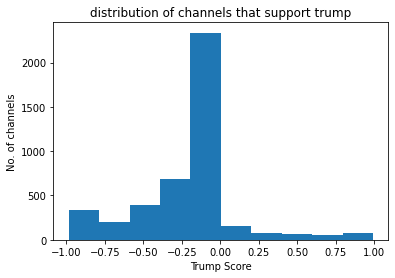

In [11]:
import matplotlib.pyplot as plt

plt.hist(tmp.to_list())
plt.xlabel('Trump Score')
plt.ylabel('No. of channels')
plt.title('distribution of channels that support trump')
plt.show()


In [5]:
columns = ['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count']
obama_df = pd.DataFrame(columns=columns)
for chunk in tqdm(pd.read_csv('data/yt_metadata_reduced.tsv.gz', chunksize=10**5, names=columns)):
    obama_df = pd.concat([obama_df, chunk[chunk['description'].str.contains('obama', case=False, na=False)]])

print(obama_df['display_id'].nunique())

0it [00:00, ?it/s]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4,6,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
5it [00:08,  1.85s/it]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
49it [01:27,  1.93s/it]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
166it [05:02,  1.82s/it]

120319


In [6]:
out = sent_analysis(obama_df['description'].to_list())
print(len(out))
temp = pd.DataFrame.from_dict(out)

120466


In [7]:
temp.to_pickle('./data/obama_sent.tsv.gz')
obama_df.to_pickle('./data/obama_data.tsv.gz')

In [8]:
obama_df = obama_df.set_index(temp.index)
obama_df = obama_df.join(temp['label'])
obama_df = obama_df.join(temp['score'])


channel_id
UC-2MJlKSq9_pYk5-bdvMhnw   -0.043446
UC-3jIAlnQmbbVMV6gR7K8aQ   -0.205013
UC-5dIHmtQzHIdNCs7-bEdCA   -0.191921
UC-6DpdmxyEh6oPQb0gVKMiQ    0.000000
UC-7HtwLZzpdC6jdGl21QukQ   -0.384928
Name: score, dtype: float64


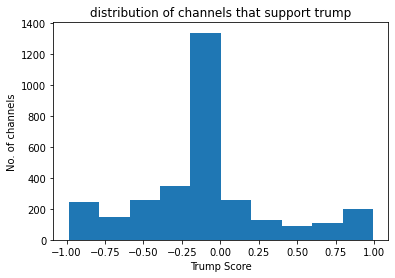

In [9]:
obama_df['label'] = obama_df['label'].map({'POS': 1.,'NEU':0., 'NEG': -1.})
obama_df['score'] = obama_df['label']*obama_df['score']
tmp = obama_df.groupby(['channel_id'])['score'].mean()
print(tmp.head(5))
df = pd.DataFrame({'score' : tmp}).reset_index()
df.head(5)
df.to_pickle('./data/obama_classified.tsv.gz')
import matplotlib.pyplot as plt

plt.hist(tmp.to_list())
plt.xlabel('Obama Score')
plt.ylabel('No. of channels')
plt.title('distribution of channels that support obama')
plt.show()

In [4]:
from transformers import pipeline
classifier = pipeline("text-classification","m-newhauser/distilbert-political-tweets",
 truncation=True,
   device='cuda:0',
   batch_size=64,
   num_workers=16)
def orient_analysis(desc):
    #print(desc)
    out = classifier(desc)
    return out

print(orient_analysis('Trump is amazing'))
print(orient_analysis('Trump is a nightmare for the country!'))
print(orient_analysis('Trump visits china for the first time, we will see how that goes!'))
print(orient_analysis('Order your Trump 2020 shirts here:'))

[{'label': 'Democrat', 'score': 0.9999856948852539}]
[{'label': 'Democrat', 'score': 0.9999961853027344}]
[{'label': 'Democrat', 'score': 0.999996542930603}]
[{'label': 'Democrat', 'score': 0.9995822310447693}]


In [69]:

columns = ['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count']
clinton_df = pd.DataFrame(columns=columns)
for chunk in tqdm(pd.read_csv('data/yt_metadata_reduced.tsv.gz', chunksize=10**5, names=columns)):
    clinton_df = pd.concat([clinton_df, chunk[chunk['description'].astype(str).str.contains('Hillary', case=False, na=False)]])

print(clinton_df['display_id'].nunique())
clinton_df.to_pickle('./data/clinton_data.tsv.gz')


0it [00:00, ?it/s]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4,6,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
5it [00:08,  1.77s/it]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
49it [01:23,  1.93s/it]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
166it [04:44,  1.72s/it]


46336


/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


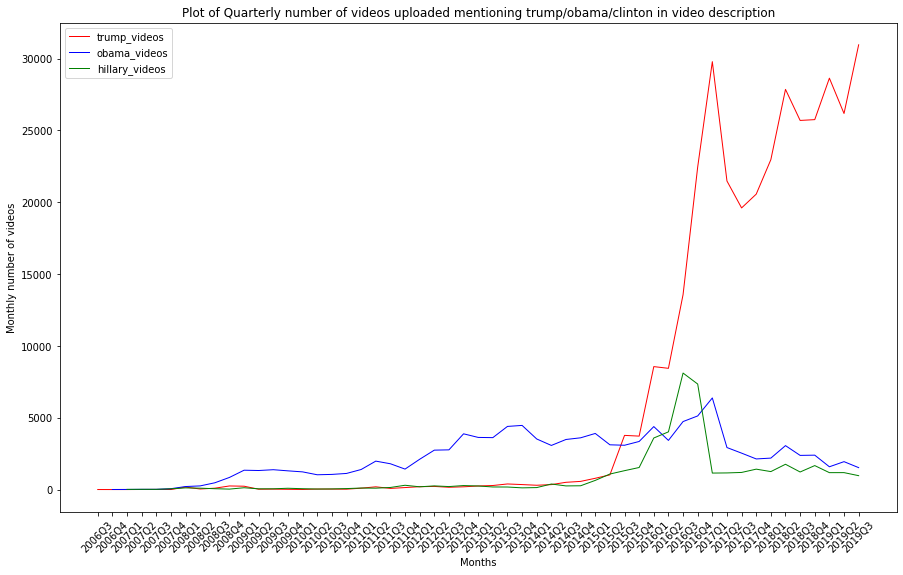

In [71]:
import datetime
trump_df = pd.read_pickle('./data/trump_data.tsv.gz')
obama_df = pd.read_pickle('./data/obama_data.tsv.gz')
clinton_df = pd.read_pickle('./data/clinton_data.tsv.gz')

trump_df['upload_date'] = pd.to_datetime(trump_df['upload_date'], errors='coerce')
trump_df['view_count'] = pd.to_numeric(trump_df['view_count'])
grouped_by_month_trump = trump_df.groupby(pd.PeriodIndex(trump_df['upload_date'], freq="Q"))

obama_df['upload_date'] = pd.to_datetime(obama_df['upload_date'], errors='coerce')
obama_df['view_count'] = pd.to_numeric(obama_df['view_count'])
grouped_by_month_obama = obama_df.groupby(pd.PeriodIndex(obama_df['upload_date'], freq="Q"))

clinton_df['upload_date'] = pd.to_datetime(clinton_df['upload_date'], errors='coerce')
clinton_df['view_count'] = pd.to_numeric(clinton_df['view_count'])
grouped_by_month_clinton = clinton_df.groupby(pd.PeriodIndex(clinton_df['upload_date'], freq="Q"))


videos_cnt_trump  = grouped_by_month_trump['display_id'].nunique()[1:-1]
videos_cnt_trump = pd.DataFrame({'count' : videos_cnt_trump}).reset_index()
videos_cnt_trump = videos_cnt_trump.set_index('upload_date').resample('Q').asfreq().fillna(0)

videos_cnt_obama  = grouped_by_month_obama['display_id'].nunique()[1:-1]
videos_cnt_obama = pd.DataFrame({'count' : videos_cnt_obama}).reset_index()
videos_cnt_obama = videos_cnt_obama.set_index('upload_date').resample('Q').asfreq().fillna(0)

videos_cnt_clinton  = grouped_by_month_clinton['display_id'].nunique()[1:-1]
videos_cnt_clinton = pd.DataFrame({'count' : videos_cnt_clinton}).reset_index()
videos_cnt_clinton = videos_cnt_clinton.set_index('upload_date').resample('Q').asfreq().fillna(0)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

ax.plot(videos_cnt_trump.index.map(str).to_list(), videos_cnt_trump['count'].to_list(), linewidth=1, color='r', label='trump_videos')
ax.plot(videos_cnt_obama.index.map(str).to_list(), videos_cnt_obama['count'].to_list(), linewidth=1, color='b', label='obama_videos')
ax.plot(videos_cnt_clinton.index.map(str).to_list(), videos_cnt_clinton['count'].to_list(), linewidth=1, color='g', label='hillary_videos')

ax.set_xticklabels(videos_cnt_trump.index.map(str).to_list(), rotation=45)


plt.xlabel('Months')
plt.ylabel('Monthly number of videos')
plt.title('Plot of Quarterly number of videos uploaded mentioning trump/obama/clinton in video description')
plt.legend()
plt.show()

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


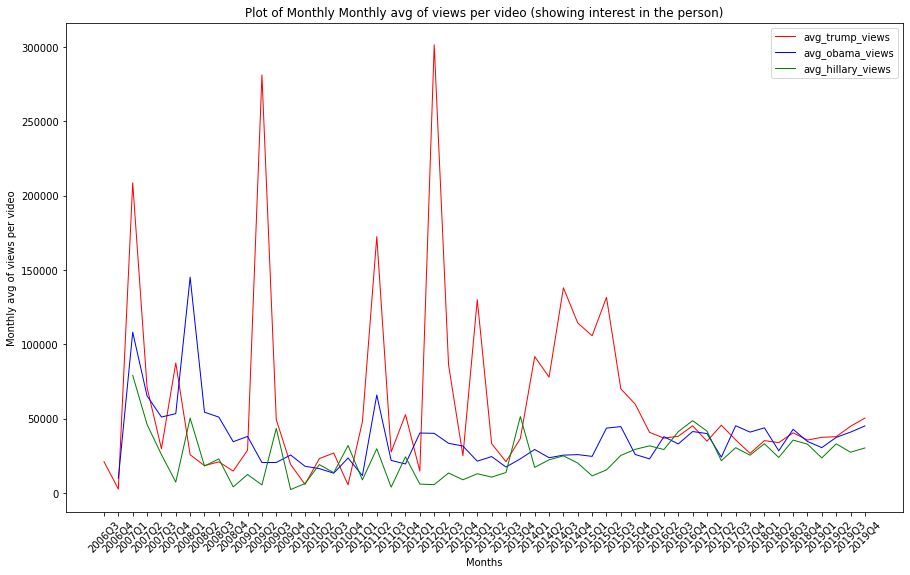

In [72]:
views_cnt_trump  = grouped_by_month_trump['view_count'].mean()[1:]
views_cnt_trump = pd.DataFrame({'count' : views_cnt_trump}).reset_index()
views_cnt_trump = views_cnt_trump.set_index('upload_date').resample('Q').asfreq().fillna(0)


views_cnt_obama  = grouped_by_month_obama['view_count'].mean()[1:]
views_cnt_obama = pd.DataFrame({'count' : views_cnt_obama}).reset_index()
views_cnt_obama = views_cnt_obama.set_index('upload_date').resample('Q').asfreq().fillna(0)

views_cnt_clinton  = grouped_by_month_clinton['view_count'].mean()[1:]
views_cnt_clinton = pd.DataFrame({'count' : views_cnt_clinton}).reset_index()
views_cnt_clinton = views_cnt_clinton.set_index('upload_date').resample('Q').asfreq().fillna(0)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

ax.plot(views_cnt_trump.index.map(str).to_list(), views_cnt_trump['count'].to_list(), linewidth=1, color='r', label='avg_trump_views')
ax.plot(views_cnt_obama.index.map(str).to_list(), views_cnt_obama['count'].to_list(), linewidth=1, color='b', label='avg_obama_views')
ax.plot(views_cnt_clinton.index.map(str).to_list(), views_cnt_clinton['count'].to_list(), linewidth=1, color='g', label='avg_hillary_views')
ax.set_xticklabels(views_cnt_trump.index.map(str).to_list(), rotation=45)
plt.xlabel('Months')
plt.ylabel('Monthly avg of views per video')
plt.title('Plot of Monthly Monthly avg of views per video (showing interest in the person)')
plt.legend()
plt.show()

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


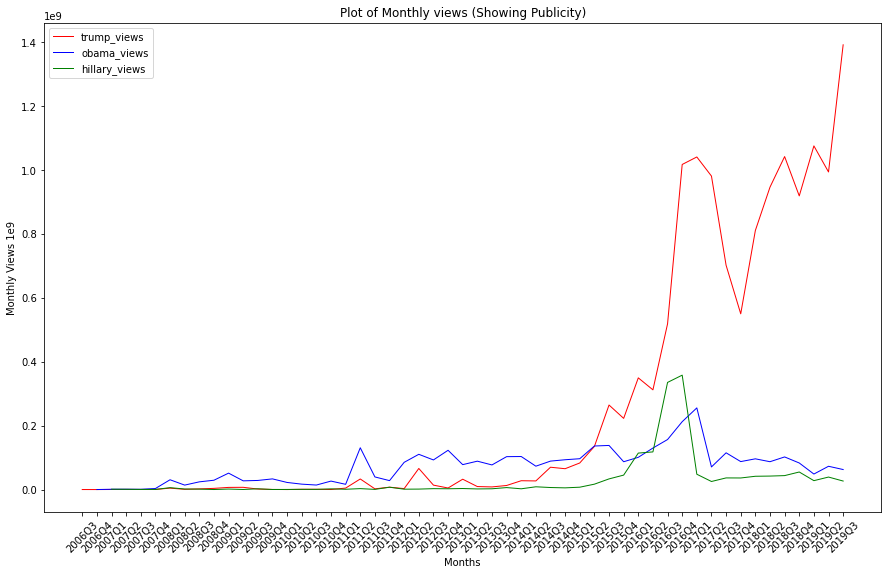

In [74]:
views_cnt_trump  = grouped_by_month_trump['view_count'].sum()[1:-1]
views_cnt_trump = pd.DataFrame({'count' : views_cnt_trump}).reset_index()
views_cnt_trump = views_cnt_trump.set_index('upload_date').resample('Q').asfreq().fillna(0)


views_cnt_obama  = grouped_by_month_obama['view_count'].sum()[1:-1]
views_cnt_obama = pd.DataFrame({'count' : views_cnt_obama}).reset_index()
views_cnt_obama = views_cnt_obama.set_index('upload_date').resample('Q').asfreq().fillna(0)

views_cnt_clinton  = grouped_by_month_clinton['view_count'].sum()[1:-1]
views_cnt_clinton = pd.DataFrame({'count' : views_cnt_clinton}).reset_index()
views_cnt_clinton = views_cnt_clinton.set_index('upload_date').resample('Q').asfreq().fillna(0)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

ax.plot(views_cnt_trump.index.map(str).to_list(), views_cnt_trump['count'].to_list(), linewidth=1, color='r', label='trump_views')
ax.plot(views_cnt_obama.index.map(str).to_list(), views_cnt_obama['count'].to_list(), linewidth=1, color='b', label='obama_views')
ax.plot(views_cnt_clinton.index.map(str).to_list(), views_cnt_clinton['count'].to_list(), linewidth=1, color='g', label='hillary_views')
ax.set_xticklabels(views_cnt_trump.index.map(str).to_list(), rotation=45)
plt.xlabel('Months')
plt.ylabel('Monthly Views 1e9')
plt.title('Plot of Monthly views (Showing Publicity)')
plt.legend()
plt.show()